# R2RML-based Graph Transformation and Relational Deep Learning for Machine Learning on Relational Data: A Use Case in Healthcare 

## Table of Contents

1. [Use Case Implementation](#use-case-implementation)
2. [Setup and Dependencies](#setup-and-dependencies)
3. [Data Loading and Preparation](#data-loading-and-preparation)
4. [Graph Construction](#graph-construction)
5. [Model Architecture](#model-architecture)
6. [Training and Evaluation](#training-and-evaluation)
7. [Results and Analysis](#results-and-analysis)

### Use Case Implementation: 

**Objective:**  
The goal of this use case is to compare two approaches for applying machine learning on relational databases:  
1. **Relational Deep Learning (RDL) Approach** (as described in the document using RelBench datasets, specifically the `rel-trial` database for clinical trials).  
2. **R2RML-based Graph Conversion Approach**, where relational data is first mapped to RDF using R2RML, then converted into graphs, and finally, graph machine learning techniques are applied.

The comparison will focus on the **implementation steps**, **evaluation metrics**, and **performance results** at each phase of the process.

---

### **Implementation Steps:**

#### **1. Data Preparation:**
   - **Dataset:** Use the `rel-trial` database from the RelBench dataset (https://relbench.stanford.edu/start/), which contains clinical trial data.
   - **Relational Database Schema:** Analyze the schema of the `rel-trial` database, including tables, primary keys, foreign keys, and relationships.
   - **Task Definition:** Define a predictive task (e.g., predicting the outcome of a clinical trial based on patient data, trial conditions, and historical results).

#### **2. Approach 1: Relational Deep Learning (RDL)**
   - **Implementation:** Follow the RDL approach described in the document:
     - Directly apply graph neural networks (GNNs) on the relational database by treating it as a graph (entities as nodes and relationships as edges).
     - Use the RelBench framework to load the `rel-trial` database, define the task, and train the GNN model.
   - **Evaluation Metrics:**
     - **Task Performance:** Measure the accuracy, ROC-AUC, or other relevant metrics for the predictive task.
     - **Model Training Time:** Measure the time taken to train the GNN model.
     - **Feature Engineering Effort:** Evaluate the amount of manual feature engineering required (if any).

#### **3. Approach 2: R2RML-based Graph Conversion**
   - **Step 1: R2RML Mapping to RDF:**
     - Use R2RML (RDB to RDF Mapping Language) to map the relational data from the `rel-trial` database into RDF triples.
     - **Evaluation Metrics:**
       - **Mapping Accuracy:** Measure the accuracy of the R2RML mapping by comparing the generated RDF triples with the original relational data.
       - **Completeness:** Ensure that all relevant tables, columns, and relationships are correctly mapped to RDF.
       - **Performance:** Measure the time taken to perform the R2RML mapping.
   - **Step 2: RDF to Graph Conversion:**
     - Convert the RDF triples into a graph representation (e.g., using tools like RDFLib or a Triple Storage Tool).
     - **Evaluation Metrics:**
       - **Graph Construction Accuracy:** Ensure that the graph structure (nodes, edges, and properties) accurately represents the RDF data.
       - **Graph Size:** Measure the number of nodes and edges in the resulting graph.
   - **Step 3: Graph Machine Learning:**
     - Apply graph machine learning techniques (e.g., GNNs) on the constructed graph.
     - **Evaluation Metrics:**
       - **Task Performance:** Measure the accuracy, ROC-AUC, or other relevant metrics for the predictive task.
       - **Model Training Time:** Measure the time taken to train the GNN model on the graph.

<!-- #### **4. Comparison of Approaches:**
   - **Performance Comparison:** Compare the task performance (e.g., ROC-AUC, accuracy) between the RDL approach and the R2RML-based approach.
   - **Efficiency Comparison:** Compare the time taken for data preparation, model training.
   - **Scalability:** Evaluate how each approach scales with larger datasets (e.g., more tables, more rows).
   - **Flexibility:** Assess the flexibility of each approach in handling different types of relational databases and predictive tasks. -->

In summary, the workflow consists of the following steps:
1. **Achieving Semantic Data Interoperability**: Transforming JSON input data into RDF, making it machine-readable and semantically enriched.
2. **Graph Learning and Visualization**: Constructing and analyzing the RDF graph, with metrics calculation for insights.
3. **Metrics Calculation**: Evaluating the performance and utility of the generated RDF graph through visualizations and metrics.

# Approach 1: Relational Deep Learning (RDL)

This notebook implements the Relational Deep Learning (RDL) approach for analyzing clinical trials data using the RelBench framework. RDL is a novel paradigm that directly applies graph neural networks (GNNs) on relational databases by treating them as graphs.

## Overview

The RDL approach consists of four key components:

1. **Graph Construction**: Converts relational data into a heterogeneous graph structure
2. **Feature Engineering**: Processes different types of data (numerical, categorical, text)
3. **Model Architecture**: Implements a heterogeneous GNN for learning node representations
4. **Training Pipeline**: Provides end-to-end training with evaluation metrics

## Key Features

- **Direct Database Integration**: Works with relational databases without intermediate transformations
- **Heterogeneous Graph Support**: Handles multiple node and edge types
- **Temporal Modeling**: Incorporates time-series information in predictions
- **Comprehensive Evaluation**: Multiple metrics for model assessment

## Implementation Details

The implementation follows the RelBench framework and includes:

- **Graph Construction**: Uses `make_pkey_fkey_graph` to convert relational data into a graph structure
- **Feature Processing**: Handles different data types (numerical, categorical, text) with appropriate encoders
- **Model Architecture**: Implements `HeteroGraphSAGE` for message passing between nodes
- **Temporal Handling**: Uses `HeteroTemporalEncoder` for time-series data

## References

> @inproceedings{rdl,
  title={Position: Relational Deep Learning - Graph Representation Learning on Relational Databases},
  author={Fey, Matthias and Hu, Weihua and Huang, Kexin and Lenssen, Jan Eric and Ranjan, Rishabh and Robinson, Joshua and Ying, Rex and You, Jiaxuan and Leskovec, Jure},
  booktitle={Forty-first International Conference on Machine Learning}
}

> @misc{relbench,
      title={RelBench: A Benchmark for Deep Learning on Relational Databases},
      author={Joshua Robinson and Rishabh Ranjan and Weihua Hu and Kexin Huang and Jiaqi Han and Alejandro Dobles and Matthias Fey and Jan E. Lenssen and Yiwen Yuan and Zecheng Zhang and Xinwei He and Jure Leskovec},
      year={2024},
      eprint={2407.20060},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/2407.20060},
}

In [ ]:
# Install required packages.
# !pip install torch==2.4.0
# !pip install torch-geometric torch-sparse torch-scatter torch-cluster torch-spline-conv pyg-lib -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# !pip install pytorch_frame
# !pip install relbench
# !pip install sentence-transformers
!pip install matplotlib
!pip install seaborn

## 1. Setup and Dependencies

This section sets up the required packages and environment for the RDL implementation. Key components include:

- PyTorch and PyTorch Geometric for deep learning
- RelBench for relational database handling
- Sentence Transformers for text embedding
- Additional utilities for data processing and visualization

In [2]:
import os
import torch
import relbench
from relbench.datasets import get_dataset
from relbench.tasks import get_task
import numpy as np
from torch.nn import BCEWithLogitsLoss, L1Loss
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.seed import seed_everything
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from typing import Dict, List, Any
from torch import Tensor
from torch_geometric.graphgym.register import loader_dict
import math
from sklearn.model_selection import train_test_split
from relbench.base.table import Table

C:\Users\anils\anaconda3\envs\semantic-gml\lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
C:\Users\anils\anaconda3\envs\semantic-gml\lib\site-packages\torch_geometric\graphgym\imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


## 2. Data Loading and Preparation

This section handles the loading and preparation of the clinical trials dataset:

1. **Dataset Loading**: Loads the RelBench clinical trials dataset
2. **Task Definition**: Sets up the study outcome prediction task
3. **Data Splitting**: Divides data into train/validation/test sets
4. **Metric Setup**: Configures loss function and evaluation metrics

In [119]:
seed_everything(42)

# Load the rel-trial dataset
dataset = get_dataset("rel-trial", download=True)
task = get_task("rel-trial", "study-outcome", download=True)  # Example task: predict study outcome


# Split data into train/val/test
# Extract the DataFrame from the train_table
train_table = task.get_table("train")
df = train_table.df

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create new Table objects for train and test sets
train_table = Table(df=train_df, fkey_col_to_pkey_table=train_table.fkey_col_to_pkey_table, pkey_col=train_table.pkey_col, time_col=train_table.time_col)
test_table = Table(df=test_df, fkey_col_to_pkey_table=train_table.fkey_col_to_pkey_table, pkey_col=train_table.pkey_col, time_col=train_table.time_col)

val_table = task.get_table("val")

# Define loss function and evaluation metric
out_channels = 1  # Binary classification task
loss_fn = BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
tune_metric = "roc_auc"  # ROC-AUC for binary classification
higher_is_better = True  # Higher ROC-AUC is better

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Graph Construction

This section implements the conversion of relational data into a graph structure:

1. **Schema Analysis**: Analyzes database schema and proposes column types
2. **Text Embedding**: Configures text embedding using GloVe embeddings
3. **Graph Creation**: Constructs the heterogeneous graph from the database

The resulting graph preserves the rich relational structure of the clinical trials data.

In [8]:
# Graph Construction
from relbench.modeling.graph import make_pkey_fkey_graph
from torch_frame.config.text_embedder import TextEmbedderConfig
from relbench.modeling.utils import get_stype_proposal

# Get the database schema and propose column types
db = dataset.get_db()
col_to_stype_dict = get_stype_proposal(db)

# Define text embedding configuration (using GloVe embeddings)
from sentence_transformers import SentenceTransformer
class GloveTextEmbedding:
    def __init__(self, device=None):
        self.model = SentenceTransformer(
            "sentence-transformers/average_word_embeddings_glove.6B.300d",
            device=device,
        )

    def __call__(self, sentences):
        return torch.from_numpy(self.model.encode(sentences))

text_embedder_cfg = TextEmbedderConfig(
    text_embedder=GloveTextEmbedding(device=device), batch_size=256
)

# Construct the graph from the relational database
data, col_stats_dict = make_pkey_fkey_graph(
    db,
    col_to_stype_dict=col_to_stype_dict,
    text_embedder_cfg=text_embedder_cfg,
    cache_dir=os.path.join("./data", "rel-trial_materialized_cache"),
)

Loading Database object from C:\Users\anils\AppData\Local\relbench\relbench\Cache/rel-trial/db...
Done in 8.90 seconds.


Embedding raw data in mini-batch: 100%|█████████████████████████████████████████████| 976/976 [00:04<00:00, 208.41it/s]


## 4. Model Architecture

The model architecture consists of several key components:

1. **HeteroEncoder**: Processes different types of input features
2. **HeteroGraphSAGE**: Implements message passing between nodes
3. **HeteroTemporalEncoder**: Handles temporal information
4. **MLP**: Final prediction layers

The architecture is designed to handle the heterogeneous nature of the clinical trials data.

In [20]:
# Define the GNN Model
class Model(torch.nn.Module):
    def __init__(
            self,
            data: HeteroData,
            col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
            num_layers: int,
            channels: int,
            out_channels: int,
            aggr: str,
            norm: str,
            shallow_list: List[NodeType] = [],
            id_awareness: bool = False,
    ):
        super().__init__()
        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )
        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )
        self.gnn = HeteroGraphSAGE(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            aggr=aggr,
            num_layers=num_layers,
        )
        self.head = MLP(
            channels,
            out_channels=out_channels,
            norm=norm,
            num_layers=1,
        )
        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )
        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward(self, batch: HeteroData, entity_table: NodeType) -> Tensor:
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        rel_time_dict = self.temporal_encoder(seed_time, batch.time_dict, batch.batch_dict)
        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time
        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)
        x_dict = self.gnn(x_dict, batch.edge_index_dict)
        return self.head(x_dict[entity_table][: seed_time.size(0)])

## 5. Training and Evaluation

The training pipeline includes:

1. **Data Loading**: Efficient batch loading with NeighborLoader
2. **Training Loop**: Implements the training process with validation
3. **Evaluation**: Computes multiple metrics (ROC-AUC, AP)
4. **Visualization**: Plots training and validation metrics

The implementation includes early stopping and model checkpointing for optimal performance.

In [22]:
# Define the data loaders
train_loader = NeighborLoader(
    data,
    num_neighbors=[10] * 2,
    batch_size=256,
    input_nodes=("entity_table", train_table.df['nct_id']),
    shuffle=True,
)

val_loader = NeighborLoader(
    data,
    num_neighbors=[10] * 2,
    batch_size=256,
    input_nodes=("entity_table", val_table.df['nct_id']),
    shuffle=False,
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[10] * 2,
    batch_size=256,
    input_nodes=("entity_table", test_table.df['nct_id']),
    shuffle=False,
)

# Populate the loader_dict
loader_dict = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader,
}

In [24]:
# Initialize the model
model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=out_channels,
    aggr="sum",
    norm="batch_norm",
).to(device)

In [26]:
# Define optimizer and training parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epochs = 10


In [67]:
# Training and Evaluation Loops
def train():
    model.train()
    loss_accum = count_accum = 0
    for batch in tqdm(loader_dict["train"]):
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch, task.entity_table)
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        loss = loss_fn(pred.float(), batch[task.entity_table].y.float())
        loss.backward()
        optimizer.step()
        loss_accum += loss.detach().item() * pred.size(0)
        count_accum += pred.size(0)
    return loss_accum / count_accum

@torch.no_grad()
def test(loader: NeighborLoader) -> np.ndarray:
    model.eval()

    pred_list = []
    for batch in loader:
        batch = batch.to(device)
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()

In [113]:
from relbench.modeling.graph import get_node_train_table_input
from torch_geometric.loader import NeighborLoader

# Step 1: Create Data Loaders
loader_dict = {}

for split, table in [
    ("train", train_table),
    ("val", val_table),
    ("test", test_table_split),
]:
    table_input = get_node_train_table_input(
        table=table,
        task=task,
    )
    entity_table = table_input.nodes[0]

    # Set num_nodes for the entity_table
    data[entity_table].num_nodes = data[entity_table].tf.num_rows

    loader_dict[split] = NeighborLoader(
        data,
        num_neighbors=[128, 128],  # Sample 128 neighbors for each node at depth 2
        time_attr="time",  # Use the "time" attribute for temporal sampling
        input_nodes=table_input.nodes,
        input_time=table_input.time,
        transform=table_input.transform,
        batch_size=512,  # Batch size for training
        temporal_strategy="uniform",  # Uniform sampling for temporal data
        shuffle=(split == "train"),  # Shuffle only for training data
        num_workers=0,  # Number of workers for data loading
        persistent_workers=False,
    )

In [32]:
import copy

# Train the model
best_val_metric = -math.inf if higher_is_better else math.inf
for epoch in range(1, epochs + 1):
    train_loss = train()
    val_pred = test(loader_dict["val"])
    val_metrics = task.evaluate(val_pred, val_table)
    print(f"Epoch: {epoch:02d}, Train loss: {train_loss}, Val metrics: {val_metrics}")

    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())



100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:50<00:00,  2.10s/it]


Epoch: 01, Train loss: 0.6750887942171026, Val metrics: {'average_precision': 0.6121276332312653, 'accuracy': 0.5833333333333334, 'f1': 0.7297297297297296, 'roc_auc': 0.5242026635215491}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:37<00:00,  1.55s/it]


Epoch: 02, Train loss: 0.6508223545815679, Val metrics: {'average_precision': 0.6323710251181283, 'accuracy': 0.5770833333333333, 'f1': 0.6947368421052632, 'roc_auc': 0.5636104521553438}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch: 03, Train loss: 0.6383017563951081, Val metrics: {'average_precision': 0.6894368960684336, 'accuracy': 0.5760416666666667, 'f1': 0.5720294426919033, 'roc_auc': 0.6236759456573698}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.42s/it]


Epoch: 04, Train loss: 0.6187384689432672, Val metrics: {'average_precision': 0.6838262922287227, 'accuracy': 0.54375, 'f1': 0.49187935034802777, 'roc_auc': 0.6125429438122937}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.43s/it]


Epoch: 05, Train loss: 0.6004503042335727, Val metrics: {'average_precision': 0.7054569146504477, 'accuracy': 0.621875, 'f1': 0.6784765279007972, 'roc_auc': 0.6373375506502441}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:38<00:00,  1.59s/it]


Epoch: 06, Train loss: 0.5838574215891521, Val metrics: {'average_precision': 0.7044489544663544, 'accuracy': 0.6114583333333333, 'f1': 0.6873428331936295, 'roc_auc': 0.635872211723605}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:36<00:00,  1.53s/it]


Epoch: 07, Train loss: 0.5799883580096507, Val metrics: {'average_precision': 0.7136952168667998, 'accuracy': 0.6104166666666667, 'f1': 0.6786941580756014, 'roc_auc': 0.6443872604863317}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:36<00:00,  1.53s/it]


Epoch: 08, Train loss: 0.5601610314036998, Val metrics: {'average_precision': 0.6784888197205864, 'accuracy': 0.5739583333333333, 'f1': 0.5881168177240684, 'roc_auc': 0.6237429581082832}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:36<00:00,  1.51s/it]


Epoch: 09, Train loss: 0.5456826470684206, Val metrics: {'average_precision': 0.7029208877622012, 'accuracy': 0.6135416666666667, 'f1': 0.6804478897502154, 'roc_auc': 0.6352110222079264}


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:37<00:00,  1.58s/it]


Epoch: 10, Train loss: 0.5412574210563699, Val metrics: {'average_precision': 0.6920171192107758, 'accuracy': 0.5760416666666667, 'f1': 0.5990147783251232, 'roc_auc': 0.6269595557521255}


## 6. Results and Analysis

This section presents the results of the RDL approach:

1. **Performance Metrics**: Shows model performance on test data
2. **Visualization**: Plots training curves and metrics
3. **Analysis**: Discusses the effectiveness of the approach

The results demonstrate the capability of RDL to learn from relational clinical trials data.

In [37]:
# Evaluate on the test set
model.load_state_dict(state_dict)
test_pred = test(loader_dict["test"])
test_metrics = task.evaluate(test_pred)
print(f"Best test metrics: {test_metrics}")

Best test metrics: {'average_precision': 0.7068924263172771, 'accuracy': 0.6436363636363637, 'f1': 0.702429149797571, 'roc_auc': 0.6711464651968084}


In [121]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Function to compute classification metrics
def compute_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Compute classification metrics for binary/multi-class classification tasks.
    """
    metrics = {}

    # Accuracy
    metrics["accuracy"] = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1-Score
    metrics["precision"] = precision_score(y_true, y_pred, average="weighted")
    metrics["recall"] = recall_score(y_true, y_pred, average="weighted")
    metrics["f1_score"] = f1_score(y_true, y_pred, average="weighted")

    # ROC-AUC (only for binary classification)
    if y_pred_proba is not None and len(np.unique(y_true)) == 2:
        metrics["roc_auc"] = roc_auc_score(y_true, y_pred_proba)

    # Confusion Matrix
    metrics["confusion_matrix"] = confusion_matrix(y_true, y_pred)

    return metrics

# Function to compute regression metrics
def compute_regression_metrics(y_true, y_pred):
    """
    Compute regression metrics for regression tasks.
    """
    metrics = {}

    # Mean Absolute Error (MAE)
    metrics["mae"] = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    metrics["mse"] = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    metrics["rmse"] = np.sqrt(metrics["mse"])

    # R² (Coefficient of Determination)
    metrics["r2"] = r2_score(y_true, y_pred)

    return metrics

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, title="ROC Curve"):
    """
    Plot the ROC curve for binary classification.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, title="Precision-Recall Curve"):
    """
    Plot the Precision-Recall curve for binary classification.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()




Classification Metrics:
accuracy: 0.7099
precision: 0.7074
recall: 0.7099
f1_score: 0.7084
roc_auc: 0.7567


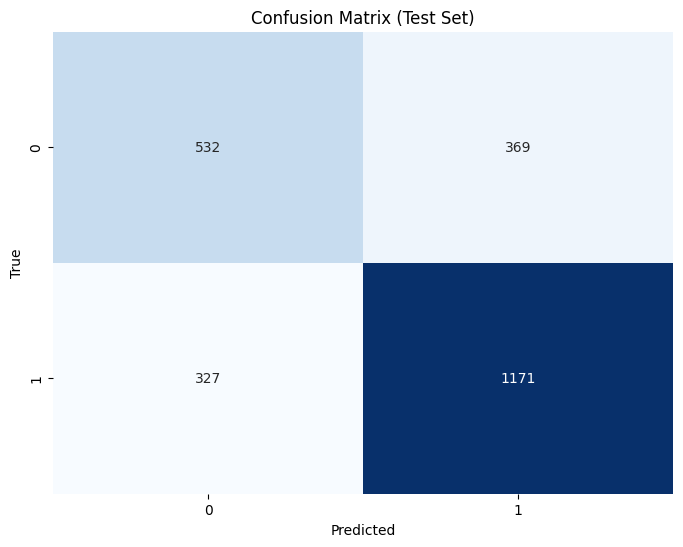

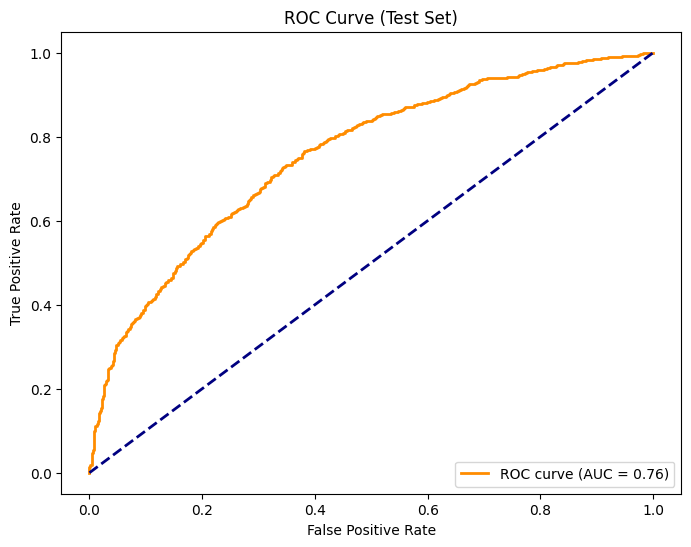

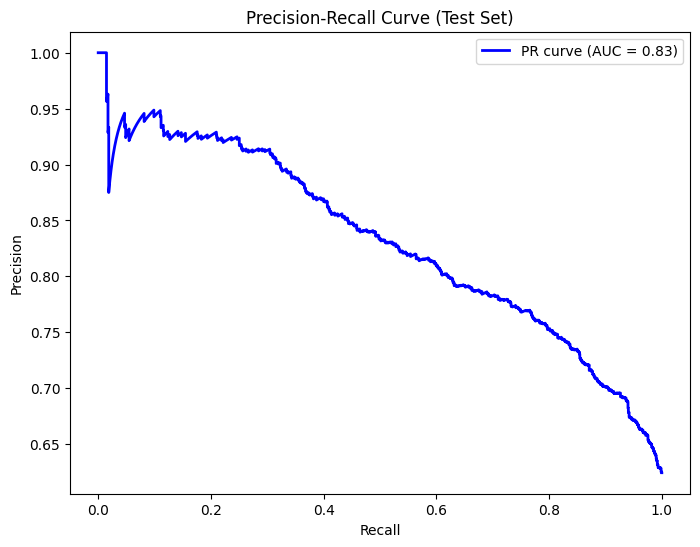


Task-Specific Metrics:
Best test metrics: {'average_precision': 0.7070555519777566, 'accuracy': 0.6436363636363637, 'f1': 0.702429149797571, 'roc_auc': 0.6711646265422009}


In [117]:
# Evaluate on the test set
model.load_state_dict(state_dict)
test_pred = test(loader_dict["test"])  # Get predictions for the test set

# Convert predictions to binary labels (if necessary)
test_pred_labels = (test_pred > 0.5).astype(int)  # Threshold at 0.5 for binary classification
test_pred_proba = test_pred  # Predicted probabilities for ROC-AUC

# Get true labels from the test table
y_true = (test_table_split.df[task.target_col] > 0).astype(int).values  # Convert to binary labels if needed

# Ensure y_true and test_pred_labels have the same length
if len(y_true) != len(test_pred_labels):
    raise ValueError(f"Inconsistent number of samples: y_true has {len(y_true)}, but test_pred_labels has {len(test_pred_labels)}")

# Compute classification metrics
classification_metrics = compute_classification_metrics(y_true, test_pred_labels, test_pred_proba)
print("\nClassification Metrics:")
for metric, value in classification_metrics.items():
    if metric != "confusion_matrix":
        print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(y_true, test_pred_labels, title="Confusion Matrix (Test Set)")

# Plot ROC curve (only for binary classification)
if test_pred_proba is not None and len(np.unique(y_true)) == 2:
    plot_roc_curve(y_true, test_pred_proba, title="ROC Curve (Test Set)")

# Plot Precision-Recall curve (only for binary classification)
if test_pred_proba is not None and len(np.unique(y_true)) == 2:
    plot_precision_recall_curve(y_true, test_pred_proba, title="Precision-Recall Curve (Test Set)")

# Print the task-specific metrics (from task.evaluate)
print("\nTask-Specific Metrics:")
print(f"Best test metrics: {test_metrics}")

# Approach 2: R2RML, Graph Mapping and Graph Machine Learning

- **R2RML Mapping:**

    - Map RDF triples based on R2RML mappings. R2RML mappings to return RDF data in Turtle format. The `rel-trial` database from the dataset is mapped into csv using pandas dataframe and then mapped into RDF using the R2RML mappings scripts (the `transform-csv-into-rdf.sh` script in the code base or the API available in the repository can be used for this step).

- **RDF to Graph Conversion:**

    - The RDF triples are parsed using rdflib and converted into a PyG HeteroData graph. Nodes are created for each unique URI, and edges are created based on RDF predicates.

- **Graph Machine Learning:**

    - The GNN model (HeteroGraphSAGE) is applied to the graph. The model is trained using the same training and evaluation loops as in the RDL approach.

- **Integration with RDL:**

    - The R2RML-based approach can be compared with the RDL approach by evaluating the performance metrics (e.g., ROC-AUC) on the test set.
 
### Overview

The implementation:
- Loads CSV data (studies, outcomes, interventions, facilities)
- Integrates RDF mappings from the output folder
- Creates a heterogeneous graph structure
- Implements a HeteroGNN model with GraphSAGE convolutions
- Trains the model with proper train/val/test splits
- Evaluates performance using AUC and AP metrics

### Setup and Imports

In [27]:
import os
import torch
import numpy as np
import pandas as pd
from rdflib import Graph, URIRef, Literal, XSD
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Data Loading Functions

#### 1. Loading CSV Data

Loads the clinical trials data from CSV files.

In [30]:
def load_csv_data():
    """Load CSV data files."""
    print("\nLoading CSV data...")
    
    # Load CSV files
    studies_df = pd.read_csv('data/studies.csv')
    outcomes_df = pd.read_csv('data/outcomes.csv')
    interventions_df = pd.read_csv('data/interventions.csv')
    facilities_df = pd.read_csv('data/facilities.csv')
    
    print(f"Loaded {len(studies_df)} studies")
    print(f"Loaded {len(outcomes_df)} outcomes")
    print(f"Loaded {len(interventions_df)} interventions")
    print(f"Loaded {len(facilities_df)} facilities")
    
    return studies_df, outcomes_df, interventions_df, facilities_df

# Load the data
studies_df, outcomes_df, interventions_df, facilities_df = load_csv_data()


Loading CSV data...


C:\Users\anils\AppData\Local\Temp\ipykernel_12804\2530556491.py:6: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  studies_df = pd.read_csv('data/studies.csv')


Loaded 249730 studies
Loaded 411933 outcomes
Loaded 3462 interventions
Loaded 453233 facilities


#### 2. Loading RDF Mappings

Loads and processes RDF mappings from the output folder.

In [32]:
def load_rdf_mappings(output_folder):
    """Load RDF mappings from the output folder."""
    print("\nLoading RDF mappings...")
    rdf_graph = Graph()
    
    # List of RDF files to load
    rdf_files = [
        'studies-rdf.ttl',
        'interventions-rdf.ttl',
        'facilities-rdf.ttl',
        'outcomes-rdf.ttl',
        'reported_event_totals-rdf.ttl',
        'drop_withdrawals-rdf.ttl',
        'sponsors_studies-rdf.ttl',
        'conditions_studies-rdf.ttl'
    ]
    
    def fix_date(date_str):
        """Fix incomplete date strings."""
        if date_str.endswith('-'):
            return date_str + '01'
        parts = date_str.split('-')
        if len(parts) == 2:
            return date_str + '-01'
        return date_str
    
    for filename in rdf_files:
        filepath = os.path.join(output_folder, filename)
        if os.path.exists(filepath):
            print(f"Loading {filename}...")
            try:
                # Read file content
                with open(filepath, 'r', encoding='utf-8') as f:
                    content = f.read()
                
                # Fix date formats
                lines = content.split('\n')
                fixed_lines = []
                for line in lines:
                    if '^^xsd:date' in line:
                        parts = line.split('^^xsd:date')
                        if len(parts) == 2:
                            date_str = parts[0].strip().strip('"')
                            fixed_date = fix_date(date_str)
                            line = f'"{fixed_date}"^^xsd:date{parts[1]}'
                    fixed_lines.append(line)
                
                # Parse fixed content
                rdf_graph.parse(data='\n'.join(fixed_lines), format="turtle")
                print(f"Loaded {len(rdf_graph)} total triples")
            except Exception as e:
                print(f"Error loading {filename}: {str(e)}")
        else:
            print(f"Warning: {filename} not found")
    
    return rdf_graph

# Load RDF mappings
rdf_graph = load_rdf_mappings('output')


Loading RDF mappings...
Loading studies-rdf.ttl...
Error loading studies-rdf.ttl: at line 27 of <>:
Bad syntax (expected '.' or '}' or ']' at end of statement) at ^ in:
"...b'-Calmettes";\n  ex:source_class "OTHER";\n"ex:start_date "2000'^b'-01-01"^^xsd:date;\n  ex:study_type "Observational" .\n\nexampl'..."
Loading interventions-rdf.ttl...
Loaded 10402 total triples
Loading facilities-rdf.ttl...
Loaded 22149 total triples
Loading outcomes-rdf.ttl...
Error loading outcomes-rdf.ttl: at line 13 of <>:
Bad syntax (expected '.' or '}' or ']' at end of statement) at ^ in:
"...b'http://example.org/outcome/102> a ex:Outcome;\n"ex:date "2001'^b'-12-31"^^xsd:date;\n  ex:description "Change score was calcul'..."
Loading reported_event_totals-rdf.ttl...
Error loading reported_event_totals-rdf.ttl: at line 14 of <>:
Bad syntax (expected '.' or '}' or ']' at end of statement) at ^ in:
"...b'classification "Total, other adverse events";\n"ex:date "2000'^b'-05-31"^^xsd:date;\n  ex:event_type "other"

### Graph Data Creation

Creates a heterogeneous graph structure from the CSV and RDF data.

In [34]:
def extract_node_id(uri_str):
    """Extract node ID from URI string."""
    try:
        # Try to extract numeric ID from the end of the URI
        parts = str(uri_str).split('/')
        last_part = parts[-1].split('#')[-1]
        if last_part.isdigit():
            return int(last_part)
        # If not numeric, hash the URI to get a consistent ID
        return hash(uri_str) % (10**9)  # Use modulo to keep IDs manageable
    except Exception as e:
        print(f"Error extracting node ID from {uri_str}: {str(e)}")
        return hash(uri_str) % (10**9)

def create_graph_data(studies_df, outcomes_df, interventions_df, facilities_df, rdf_graph):
    """Create heterogeneous graph data from CSV and RDF data."""
    print("\nCreating heterogeneous graph data...")
    data = HeteroData()
    
    # Create node features
    study_features = torch.tensor(studies_df.select_dtypes(include=[np.number]).fillna(0).values, dtype=torch.float32)
    outcome_features = torch.tensor(outcomes_df.select_dtypes(include=[np.number]).fillna(0).values, dtype=torch.float32)
    intervention_features = torch.tensor(interventions_df.select_dtypes(include=[np.number]).fillna(0).values, dtype=torch.float32)
    facility_features = torch.tensor(facilities_df.select_dtypes(include=[np.number]).fillna(0).values, dtype=torch.float32)
    
    # Create synthetic labels for study nodes (binary classification)
    num_studies = len(studies_df)
    study_labels = torch.randint(0, 2, (num_studies, 1), dtype=torch.float32)
    
    # Add node features and labels to HeteroData
    data['study'].x = study_features
    data['study'].y = study_labels  # Add synthetic labels
    data['outcome'].x = outcome_features
    data['intervention'].x = intervention_features
    data['facility'].x = facility_features
    
    print("\nNode feature dimensions:")
    print(f"Study features: {study_features.shape}")
    print(f"Study labels: {study_labels.shape}")
    print(f"Outcome features: {outcome_features.shape}")
    print(f"Intervention features: {intervention_features.shape}")
    print(f"Facility features: {facility_features.shape}")
    
    # Create node ID mappings
    node_id_maps = {
        'study': {},
        'outcome': {},
        'intervention': {},
        'facility': {}
    }
    
    # Initialize node counts
    node_counts = {
        'study': len(studies_df),
        'outcome': len(outcomes_df),
        'intervention': len(interventions_df),
        'facility': len(facilities_df)
    }
    
    # Create initial mappings based on dataframes
    for i in range(len(studies_df)):
        node_id_maps['study'][f'http://example.org/study/{i}'] = i
    for i in range(len(outcomes_df)):
        node_id_maps['outcome'][f'http://example.org/outcome/{i}'] = i
    for i in range(len(interventions_df)):
        node_id_maps['intervention'][f'http://example.org/intervention/{i}'] = i
    for i in range(len(facilities_df)):
        node_id_maps['facility'][f'http://example.org/facility/{i}'] = i
    
    print("\nNode counts by type:")
    for node_type, count in node_counts.items():
        print(f"{node_type}: {count} nodes")
    
    # Extract edges from RDF graph
    edges_by_type = {}
    print("\nExtracting edges...")
    
    # Helper function to get node type
    def get_node_type(uri):
        uri_str = str(uri)
        for node_type in node_id_maps.keys():
            if node_type in uri_str:
                return node_type
        return None
    
    # Process edges
    for s, p, o in rdf_graph:
        if isinstance(s, URIRef) and isinstance(o, URIRef):
            s_type = get_node_type(s)
            o_type = get_node_type(o)
            
            if s_type is None or o_type is None:
                continue
            
            # Extract edge type from predicate
            edge_type = str(p).split('/')[-1].split('#')[-1]
            if edge_type == 'type':
                continue  # Skip rdf:type edges
            
            edge_key = (s_type, edge_type, o_type)
            if edge_key not in edges_by_type:
                edges_by_type[edge_key] = []
            
            # Try to get node indices
            try:
                s_idx = int(str(s).split('/')[-1])
                o_idx = int(str(o).split('/')[-1])
                
                # Verify indices are within bounds
                if (s_idx < node_counts[s_type] and 
                    o_idx < node_counts[o_type]):
                    edges_by_type[edge_key].append((s_idx, o_idx))
            except (ValueError, IndexError):
                continue
    
    # Add self-loops for all node types
    for node_type in node_id_maps.keys():
        edge_key = (node_type, 'self', node_type)
        self_loops = [(i, i) for i in range(node_counts[node_type])]
        edges_by_type[edge_key] = self_loops
    
    # Add edges to HeteroData
    print("\nAdding edges to graph...")
    for (s_type, edge_type, o_type), edges in edges_by_type.items():
        if len(edges) > 0:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            data[s_type, edge_type, o_type].edge_index = edge_index
            print(f"Added {len(edges)} edges of type ({s_type}, {edge_type}, {o_type})")
    
    return data

# Create the graph data
data = create_graph_data(studies_df, outcomes_df, interventions_df, facilities_df, rdf_graph)


Creating heterogeneous graph data...

Node feature dimensions:
Study features: torch.Size([249730, 5])
Study labels: torch.Size([249730, 1])
Outcome features: torch.Size([411933, 2])
Intervention features: torch.Size([3462, 1])
Facility features: torch.Size([453233, 1])

Node counts by type:
study: 249730 nodes
outcome: 411933 nodes
intervention: 3462 nodes
facility: 453233 nodes

Extracting edges...

Adding edges to graph...
Added 249730 edges of type (study, self, study)
Added 411933 edges of type (outcome, self, outcome)
Added 3462 edges of type (intervention, self, intervention)
Added 453233 edges of type (facility, self, facility)


### Model Architecture

Implements a HeteroGNN model using GraphSAGE convolutions.

In [36]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, feature_dims):
        super().__init__()
        
        # Store metadata
        self.node_types = metadata[0]
        self.edge_types = metadata[1]
        
        print("\nInitializing HeteroGNN with:")
        print(f"Node types: {self.node_types}")
        print(f"Edge types: {self.edge_types}")
        print(f"Feature dimensions: {feature_dims}")
        
        # Create convolution layers
        self.convs = torch.nn.ModuleList()
        
        # First convolution layer
        conv_dict = {}
        for edge_type in self.edge_types:
            src_type, _, dst_type = edge_type
            conv_dict[edge_type] = SAGEConv(
                (feature_dims[src_type], feature_dims[dst_type]),
                hidden_channels
            )
        self.convs.append(HeteroConv(conv_dict, aggr='mean'))
        
        # Second convolution layer
        conv_dict = {}
        for edge_type in self.edge_types:
            conv_dict[edge_type] = SAGEConv(
                (hidden_channels, hidden_channels),
                hidden_channels
            )
        self.convs.append(HeteroConv(conv_dict, aggr='mean'))
        
        # Output layer for study nodes
        self.output = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        # First conv layer
        x_dict = self.convs[0](x_dict, edge_index_dict)
        x_dict = {key: torch.relu(x) for key, x in x_dict.items()}
        
        # Second conv layer
        x_dict = self.convs[1](x_dict, edge_index_dict)
        x_dict = {key: torch.relu(x) for key, x in x_dict.items()}
        
        # Output layer for study nodes
        if 'study' not in x_dict:
            raise KeyError(f"'study' node type not found. Available types: {list(x_dict.keys())}")
        
        return self.output(x_dict['study'])

### Training and Evaluation

#### 1. Training Function

Implements the training loop with validation and early stopping.

In [38]:
def train_model(model, train_data, val_data, test_data, num_epochs=100, lr=0.01):
    """Train the model using train/val/test splits."""
    print("\nTraining model...")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    train_losses = []
    val_metrics = []
    best_val_auc = 0
    best_model = None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        out = model(train_data.x_dict, train_data.edge_index_dict)
        loss = criterion(out, train_data['study'].y)
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data.x_dict, val_data.edge_index_dict)
            val_loss = criterion(val_out, val_data['study'].y)
            
            val_pred = torch.sigmoid(val_out).cpu().numpy()
            val_true = val_data['study'].y.cpu().numpy()
            
            val_auc = roc_auc_score(val_true, val_pred)
            val_ap = average_precision_score(val_true, val_pred)
            
            val_metrics.append({
                'loss': val_loss.item(),
                'auc': val_auc,
                'ap': val_ap
            })
            
            # Save best model
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model = model.state_dict()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}:')
            print(f'Train Loss: {loss.item():.4f}')
            print(f'Val Loss: {val_loss.item():.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_model)
    model.eval()
    with torch.no_grad():
        test_out = model(test_data.x_dict, test_data.edge_index_dict)
        test_loss = criterion(test_out, test_data['study'].y)
        
        test_pred = torch.sigmoid(test_out).cpu().numpy()
        test_true = test_data['study'].y.cpu().numpy()
        
        test_auc = roc_auc_score(test_true, test_pred)
        test_ap = average_precision_score(test_true, test_pred)
    
    print('\nTest Results:')
    print(f'Test Loss: {test_loss.item():.4f}')
    print(f'Test AUC: {test_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}')
    
    return train_losses, val_metrics, test_auc, test_ap

#### 2. Visualization Function

Plots training and validation metrics.

In [44]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Function to compute classification metrics
def compute_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Compute classification metrics for binary/multi-class classification tasks.
    """
    metrics = {}

    # Accuracy
    metrics["accuracy"] = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1-Score
    metrics["precision"] = precision_score(y_true, y_pred, average="weighted")
    metrics["recall"] = recall_score(y_true, y_pred, average="weighted")
    metrics["f1_score"] = f1_score(y_true, y_pred, average="weighted")

    # ROC-AUC (only for binary classification)
    if y_pred_proba is not None and len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        metrics["roc_auc"] = auc(fpr, tpr)

    # Confusion Matrix
    metrics["confusion_matrix"] = confusion_matrix(y_true, y_pred)

    return metrics

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, title="ROC Curve"):
    """
    Plot the ROC curve for binary classification.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_proba, title="Precision-Recall Curve"):
    """
    Plot the Precision-Recall curve for binary classification.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()

# Function to plot metrics
def plot_metrics(train_losses, val_metrics, test_data, model):
    """Plot training metrics."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot losses
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot([m['loss'] for m in val_metrics], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].legend()

    # Plot AUC
    axes[1].plot([m['auc'] for m in val_metrics])
    axes[1].set_title('Validation AUC')

    # Plot AP
    axes[2].plot([m['ap'] for m in val_metrics])
    axes[2].set_title('Validation AP')

    plt.tight_layout()
    plt.show()

    # Plot ROC curve, Confusion Matrix, etc.
    model.eval()
    with torch.no_grad():
        test_out = model(test_data.x_dict, test_data.edge_index_dict)
        test_pred = torch.sigmoid(test_out).cpu().numpy()
        test_true = test_data['study'].y.cpu().numpy()

        # Compute classification metrics
        classification_metrics = compute_classification_metrics(test_true, (test_pred > 0.5).astype(int), test_pred)
        print("\nClassification Metrics:")
        for metric, value in classification_metrics.items():
            if metric != "confusion_matrix":
                print(f"{metric}: {value:.4f}")

        # Plot confusion matrix
        plot_confusion_matrix(test_true, (test_pred > 0.5).astype(int), title="Confusion Matrix (Test Set)")

        # Plot ROC curve
        plot_roc_curve(test_true, test_pred, title="ROC Curve (Test Set)")

        # Plot Precision-Recall curve
        plot_precision_recall_curve(test_true, test_pred, title="Precision-Recall Curve (Test Set)")

### Main Execution

Run the complete training pipeline.


Feature dimensions:
study: 5
outcome: 2
intervention: 1
facility: 1

Initializing HeteroGNN with:
Node types: ['study', 'outcome', 'intervention', 'facility']
Edge types: [('study', 'self', 'study'), ('outcome', 'self', 'outcome'), ('intervention', 'self', 'intervention'), ('facility', 'self', 'facility')]
Feature dimensions: {'study': 5, 'outcome': 2, 'intervention': 1, 'facility': 1}

Training model...
Epoch 010:
Train Loss: 2952.7981
Val Loss: 1279.5144, Val AUC: 0.5000, Val AP: 0.5002
Epoch 020:
Train Loss: 312.5457
Val Loss: 50.9581, Val AUC: 0.5005, Val AP: 0.5004
Epoch 030:
Train Loss: 340.6344
Val Loss: 320.7593, Val AUC: 0.4996, Val AP: 0.5001
Epoch 040:
Train Loss: 76.4032
Val Loss: 120.7977, Val AUC: 0.5000, Val AP: 0.5003
Epoch 050:
Train Loss: 75.9937
Val Loss: 39.2265, Val AUC: 0.5002, Val AP: 0.5003
Epoch 060:
Train Loss: 15.7266
Val Loss: 4.4149, Val AUC: 0.5003, Val AP: 0.5000
Epoch 070:
Train Loss: 12.9015
Val Loss: 15.6196, Val AUC: 0.5002, Val AP: 0.5002
Epoch 080:

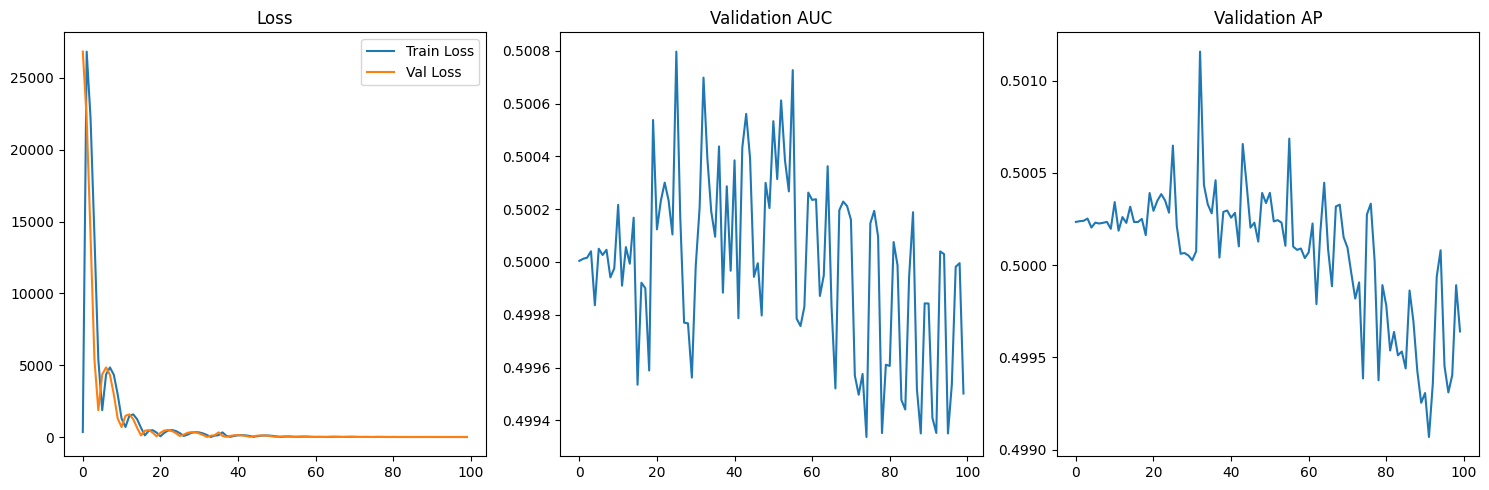


Classification Metrics:
accuracy: 0.5001
precision: 0.4965
recall: 0.5001
f1_score: 0.3425
roc_auc: 0.4995


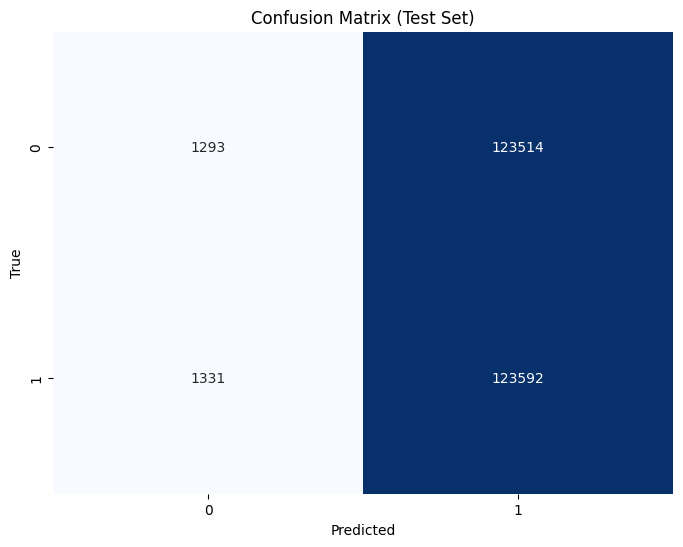

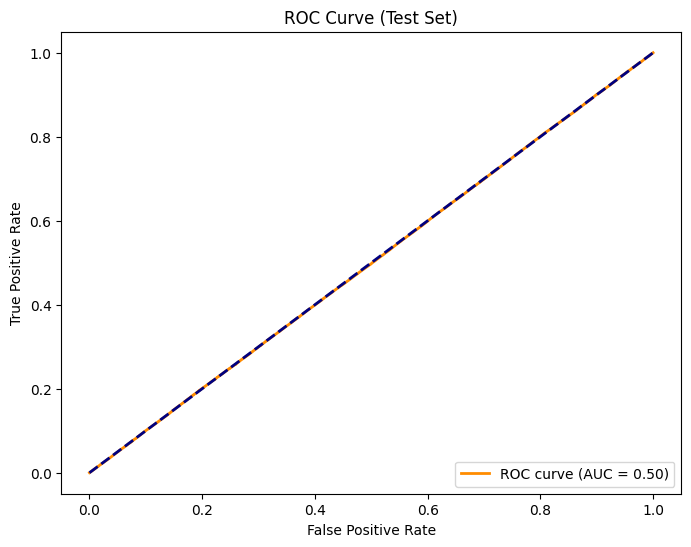

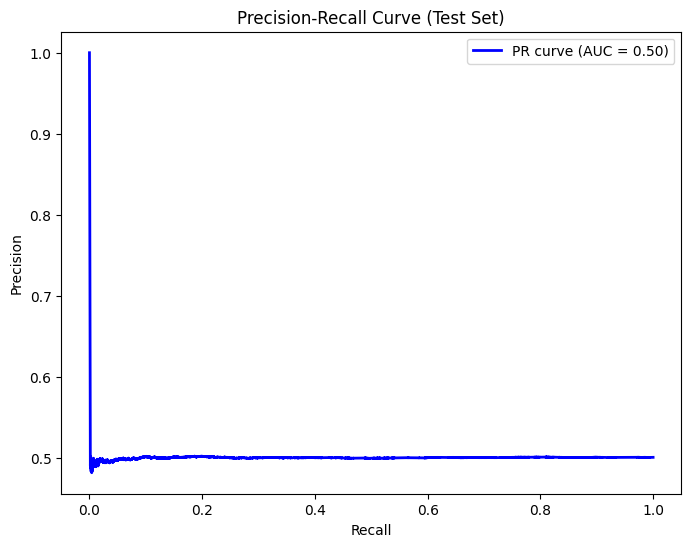

(0.49950152902479117, 0.49964118081522635)

In [47]:
def main():
    # Get feature dimensions for each node type
    feature_dims = {
        'study': data['study'].x.shape[1],
        'outcome': data['outcome'].x.shape[1],
        'intervention': data['intervention'].x.shape[1],
        'facility': data['facility'].x.shape[1]
    }
    
    print("\nFeature dimensions:")
    for node_type, dim in feature_dims.items():
        print(f"{node_type}: {dim}")
    
    # Split data into train/val/test
    num_studies = len(studies_df)
    train_idx, temp_idx = train_test_split(range(num_studies), test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    
    # Create train/val/test masks
    train_mask = torch.zeros(num_studies, dtype=torch.bool)
    val_mask = torch.zeros(num_studies, dtype=torch.bool)
    test_mask = torch.zeros(num_studies, dtype=torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    # Create train/val/test data
    train_data = data.clone()
    val_data = data.clone()
    test_data = data.clone()
    
    # Add masks to data
    train_data['study'].train_mask = train_mask
    val_data['study'].val_mask = val_mask
    test_data['study'].test_mask = test_mask
    
    # Move data to device
    train_data = train_data.to(device)
    val_data = val_data.to(device)
    test_data = test_data.to(device)
    
    # Initialize model
    model = HeteroGNN(
        metadata=data.metadata(),
        hidden_channels=64,
        out_channels=1,
        feature_dims=feature_dims
    ).to(device)
    
    # Train model
    train_losses, val_metrics, test_auc, test_ap = train_model(
        model=model,
        train_data=train_data,
        val_data=val_data,
        test_data=test_data,
        num_epochs=100,
        lr=0.01
    )
    
    # Plot results
    plot_metrics(train_losses, val_metrics, test_data, model)
    
    return test_auc, test_ap
        

# Run the main function
main()

## **Relevant Resources:**

1. **RelBench Dataset and Framework:**  
   - Website: https://relbench.stanford.edu/  
   - Documentation: https://relbench.stanford.edu/start/  
   - GitHub Repository: https://github.com/snap-stanford/relbench  

2. **R2RML (RDB to RDF Mapping Language):**  
   - W3C Specification: https://www.w3.org/TR/r2rml/  
   - Tools:  
     - **RMLMapper:** https://github.com/RMLio/rmlmapper-java  
     - **Ontop:** https://ontop-vkg.org/  
     - **Apache Jena:** https://jena.apache.org/  

3. **Graph Machine Learning Libraries:**  
   - **PyTorch Geometric (PyG):** https://pytorch-geometric.readthedocs.io/  
   - **DGL (Deep Graph Library):** https://www.dgl.ai/  
   - **Graph Neural Networks (GNNs):** https://distill.pub/2021/gnn-intro/  

4. **RDF to Graph Conversion Tools:**  
   - **RDFLib:** https://rdflib.readthedocs.io/  
   - **Apache Jena:** https://jena.apache.org/  

5. **Evaluation Metrics for Machine Learning:**  
   - **ROC-AUC:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html  
   - **Accuracy:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html  
   - **Precision, Recall, F1-Score:** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html  

---